# EDA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import service_func.service_func as serv

In [3]:
train = pd.read_csv('data/train.csv')
member = pd.read_csv('data/members.csv')
songs = pd.read_csv('data/songs.csv')
extra_song = pd.read_csv('data/song_extra_info.csv')

## 1  Train Data Exploration

In [3]:
# train data
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


Набор train.csv содержит 6 столбцов:
- `msn`: уникальный идентификатор пользователя;
- `song_id`: уникальный идентификатор песни;
- `source_system_tab`: название вкладки, на которой было запущено событие;
- `source_screen_name`: название макета, который видит пользователь;
- `source_type`: точка входа, с которой пользователь впервые воспроизводит музыку в мобильном приложении. Точкой входа может быть альбом, онлайн-плейлист, песня и т.д.
- `target`: целевая переменная. Значение target=1 означает, что в течение месяца после первого прослушивания пользователь еще хотя бы раз прослушивал композицию, в противном случае значение target=0.

### 1.1 Количество уникальных значений.

In [4]:
# в данном случае удобнее было использовать не pd.value_counts, а кастомную функцию
serv.summary(train)

Total number of records:  7377418
Distinct msno in dataframe: 30755
Distinct song_id in dataframe: 359966
Distinct source_system_tab in dataframe: 9
Distinct source_screen_name in dataframe: 21
Distinct source_type in dataframe: 13
Distinct target in dataframe: 2


### 1.2 Есть ли дисбаланс классов?

In [5]:
np.mean(train.target)

0.5035170841614234

Данные сбалансированы по таргет-переменной.

### 1.3 Проверка пропущенных значений.

In [ ]:
serv.count_na(train)

,NA_count,Percentage
msno,0,0.000000
song_id,0,0.000000
source_system_tab,24849,0.336825
source_screen_name,414804,5.622618
source_type,21539,0.291959
target,0,0.000000


Мы видим, что у нас отсутствуют некоторые значения для `source system tab`, `source screen name` и `source type`. Следовательно, прежде чем мы начнем создавать модели, нужно будет обработать пропущенные значения.

### 1.4 Распределение категориальных переменных.

  Source System Tab    Count
3        my library  3684730
0          discover  2179252
6            search   623286
5             radio   476701
2       listen with   212266
1           explore   167949
4      notification     6185
7          settings     2200


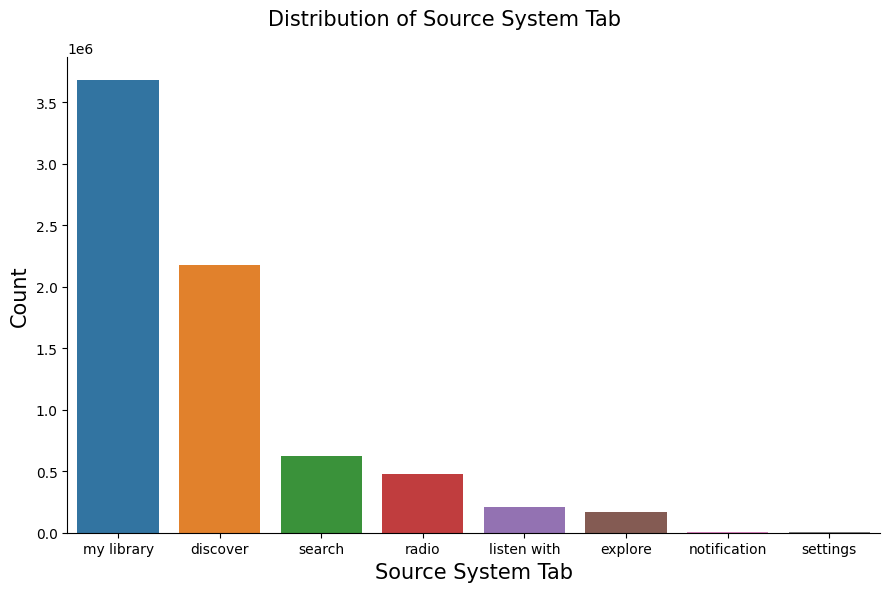

In [28]:
a = train.groupby('source_system_tab').size()
a = pd.DataFrame(a)
a.reset_index(level=0, inplace=True)
a.columns = ['Source System Tab', 'Count']
a = a.sort_values(by='Count', ascending=False)
print(a)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Source System Tab', y='Count', kind='bar',
                 data=a, height=6, hue='Source System Tab', legend=False, aspect=1.5)
ax.figure.suptitle('Distribution of Source System Tab', fontsize=15)
ax.figure.subplots_adjust(top=.9)
plt.show()

Мы видим, что большинство прослушиваний было осуществлено с `my library`, затем идут `discover` and `search`. 
Давайте рассмотрим ту же зависимость в отношении процента повторений, чтобы увидеть, какой вид `source system tab` вносит максимальный вклад в повторение прослушивания.

                     target
source_system_tab          
my library         0.619659
settings           0.590909
explore            0.422146
search             0.421362
discover           0.415770
notification       0.378011
listen with        0.326581
radio              0.222662


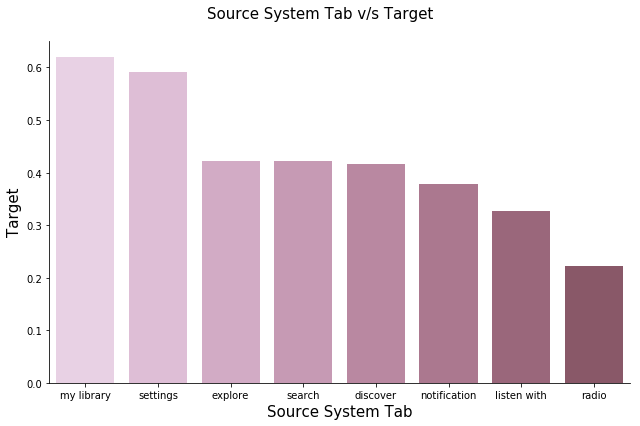

In [8]:
repeat_df = train.groupby(['source_system_tab']).mean(
).sort_values(by='target', ascending=False)
print(repeat_df)

repeat_df.reset_index(level=0, inplace=True)
repeat_df.columns = ['Source System Tab', 'Target']
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Source System Tab', y='Target', kind='bar', palette="ch:7,-.2,dark=.4",
                 data=repeat_df, height=6, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Source System Tab v/s Target', fontsize=15)
plt.show()

Как и предполагалось, `my library` имеет максимальный вклад, далее - столбцы `settings`, `explore`, `search` и `discover`. Обратите внимание, что на `settings` and `explore` приходится меньше событий, но конверсия высока.

#### Некоторые инсайты по столбцам `source screen name` и `source type`.

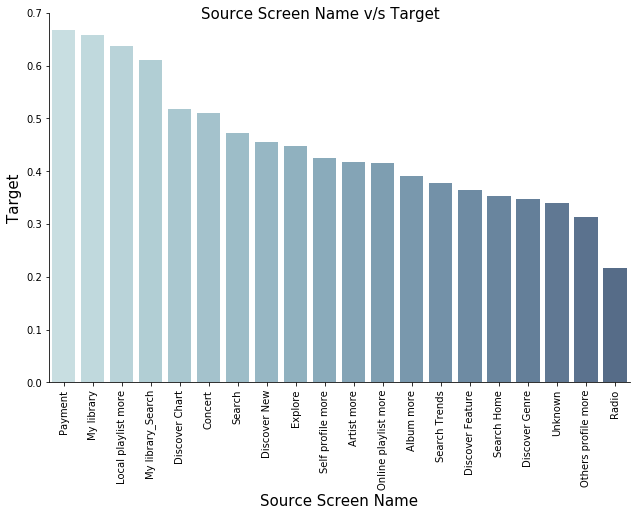

In [9]:
ss_name = train.groupby(['source_screen_name']).mean().sort_values(by='target', ascending=False)
ss_name.reset_index(level=0, inplace=True)
ss_name.columns = ['Source Screen Name', 'Target']

plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Source Screen Name', y='Target', kind='bar', palette="ch:12,-.2,dark=.4",
                 data=ss_name, height=6, aspect=1.5)
ax.figure.suptitle('Source Screen Name v/s Target', fontsize=15)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)

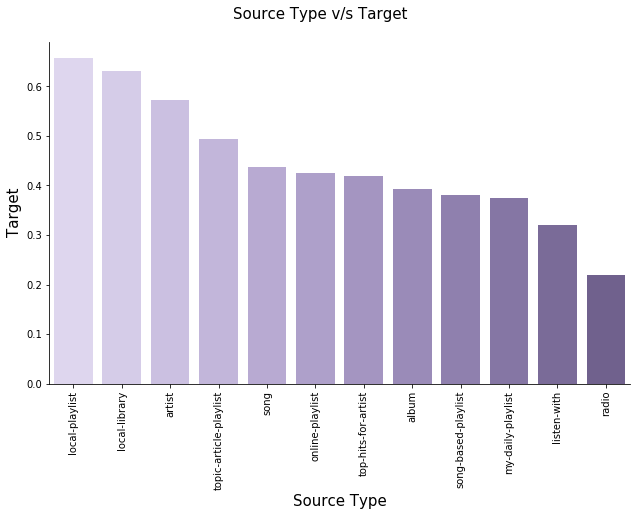

In [10]:
s_type = train.groupby(['source_type']).mean().sort_values(by='target', ascending=False)
s_type.reset_index(level=0, inplace=True)
s_type.columns = ['Source Type', 'Target']

plt.rcParams["axes.labelsize"] = 15

ax = sns.catplot(x='Source Type', y='Target', kind='bar', palette="ch:.12,0,dark=.4",
                 data=s_type, height=6, aspect=1.5)
ax.fiure.subplots_adjust(top=.9)
ax.figure.suptitle('Source Type v/s Target', fontsize=15)

for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)

### 1.5 Количество ре-прослушиваний треков и самая популярная песня.

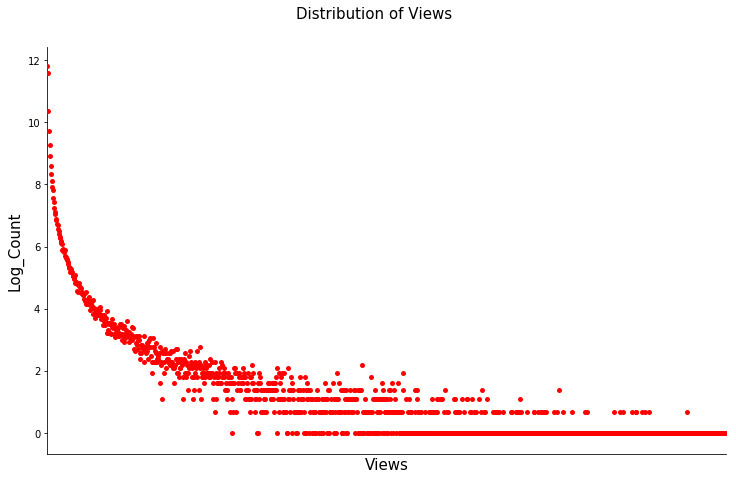

In [11]:
###
grpb = train.groupby(['song_id']).sum().sort_values(by='target', ascending=False)
grpb.reset_index(level=0, inplace=True)
grpb.columns = ['Source Type', 'Views']

new = grpb.groupby(['Views']).count()
new.reset_index(inplace=True)
new.columns = ['Views', 'Log_Count']
new['Log_Count'] = np.log(new.Log_Count)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Views', y='Log_Count', kind='strip', color='red', height=7, aspect=1.5,
                 data=new)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of Views', fontsize=15)
ax.set(xticks=[])
plt.show()

Как можно видеть, чаще всего трек переслушивают 1 раз.

## 2 Member Data Exploration

In [8]:
member.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [9]:
member.registration_init_time = pd.to_datetime(
    member.registration_init_time.astype('str'))
member.expiration_date = pd.to_datetime(member.expiration_date.astype('str'))

In [10]:
member.dtypes

msno                              object
city                               int64
bd                                 int64
gender                            object
registered_via                     int64
registration_init_time    datetime64[ns]
expiration_date           datetime64[ns]
dtype: object

#### В наборе данных 7 столбцов. Описание столбцов:
- `msno`: уникальный user id
- `city`: город
- `bd`: возраст<br>
- `gender`: гендер <br>
- `registered_via`: метод регистрации <br>
- `registration_init_time`: время регистрации в формате %Y%m%d <br>
- `expiration_date`: формат %Y%m%d <br>



### 2.1 Подсёт значений датасета member.

In [11]:
serv.summary(member)

Total number of records:  34403
Distinct msno in dataframe: 34403
Distinct city in dataframe: 21
Distinct bd in dataframe: 95
Distinct gender in dataframe: 3
Distinct registered_via in dataframe: 6
Distinct registration_init_time in dataframe: 3862
Distinct expiration_date in dataframe: 1484


In [12]:
member.describe()

,city,bd,registered_via,registration_init_time,expiration_date
count,34403.000000,34403.000000,34403.000000,34403,34403
mean,5.371276,12.280935,5.953376,2014-06-07 19:28:51.093218560,2017-06-03 10:39:36.839229184
min,1.000000,-43.000000,3.000000,2004-03-26 00:00:00,1970-01-01 00:00:00
25%,1.000000,0.000000,4.000000,2012-10-27 00:00:00,2017-02-01 00:00:00
50%,1.000000,0.000000,7.000000,2015-09-05 00:00:00,2017-09-09 00:00:00
75%,10.000000,25.000000,9.000000,2016-11-02 00:00:00,2017-09-30 00:00:00
max,22.000000,1051.000000,16.000000,2017-02-28 00:00:00,2020-10-17 00:00:00
std,6.243929,18.170251,2.287534,NaN,NaN


Обратите внимание, что город и метод регистрации были закодированы численно. Также заметим, что у нас много выбросов в данных о возрасте, которые необходимо обработать.

### 2.2 Пропущенные значения.

In [13]:
serv.count_na(member)

,NA_count,Percentage
msno,0,0.000000
city,0,0.000000
bd,0,0.000000
gender,19902,57.849606
registered_via,0,0.000000
registration_init_time,0,0.000000
expiration_date,0,0.000000


Почти в **~58%** строк не указан гендер.

### 2.3 Распределение категориальных переменных.

#### Distribution of City IDs

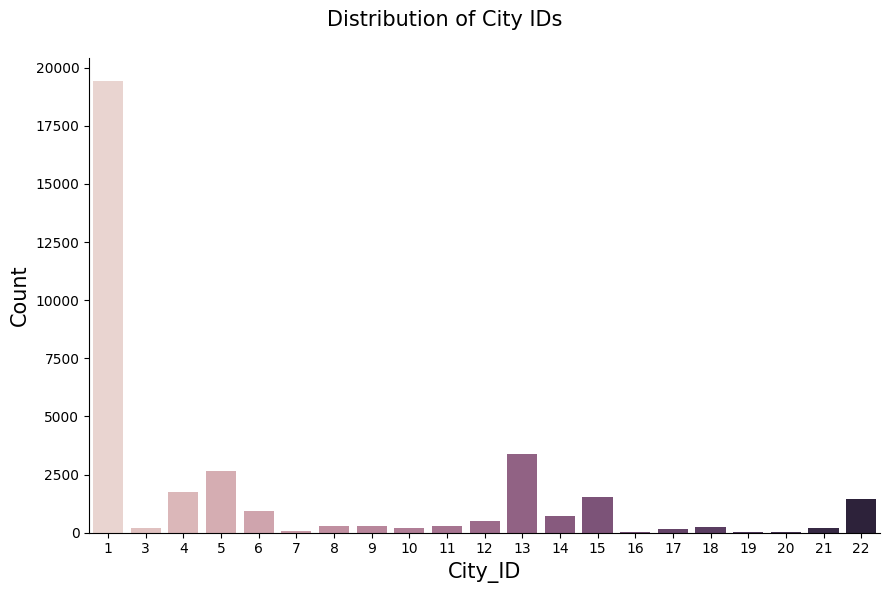

In [30]:
city = member.groupby(['city']).size()
city = pd.DataFrame(city)
city.reset_index(level=0, inplace=True)
city.columns = ['City_ID', 'Count']
#city = city.sort_values(by='Count', ascending=False)

plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='City_ID', y='Count', kind='bar', hue='City_ID', legend=False, 
                 data=city, height=6, aspect=1.5)
ax.figure.subplots_adjust(top=.9)
ax.figure.suptitle('Distribution of City IDs', fontsize=15)
plt.show()

Самый часто встречающийся (с большим отрывом) город -  `1`.

#### Распрделение по гендеру

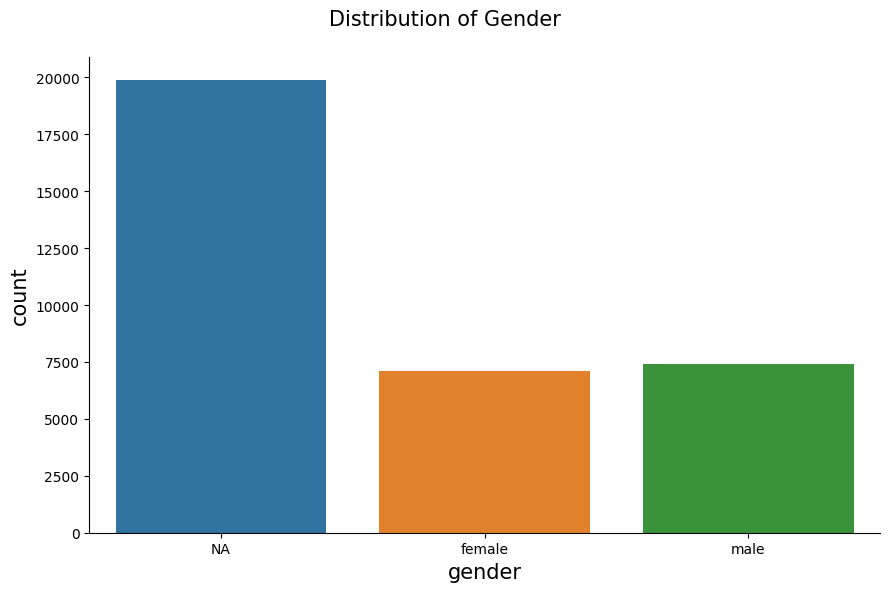

In [25]:
member['gender'] = member.gender.replace(np.NaN, 'NA')
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='gender', kind='count', hue='gender', legend=False, #palette="ch:23,0.3,dark=.4",
                 data=member, height=6, aspect=1.5)
ax.figure.subplots_adjust(top=.9)
ax.figure.suptitle('Distribution of Gender', fontsize=15)
plt.show()

Как видно из диаграммы, большинство не указывало свой гендер, а соотношение мужчин к женщинам примерно равно 1.

#### Распрделение по Registration Via

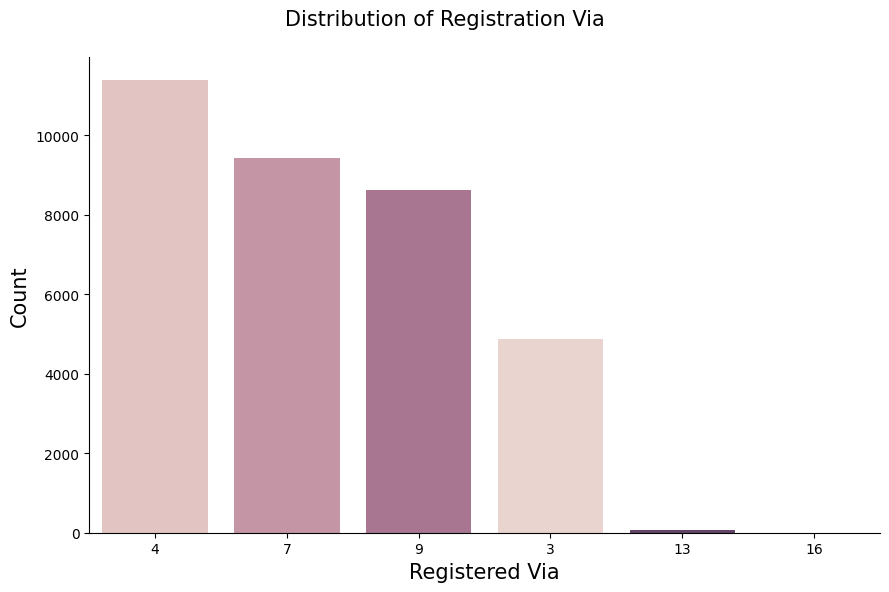

In [27]:
registered_via = member.groupby(['registered_via']).size()
registered = pd.DataFrame(registered_via)
registered.reset_index(level=0, inplace=True)
registered.columns = ['Registered Via', 'Count']
registered = registered.sort_values(by='Count', ascending=False)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Registered Via', y='Count', kind='bar', order=registered['Registered Via'],
                hue='Registered Via', legend=False,  data=registered, height=6, aspect=1.5)
ax.figure.subplots_adjust(top=.9)
ax.figure.suptitle('Distribution of Registration Via', fontsize=15)
plt.show()

#### Распрделение по Registration Date

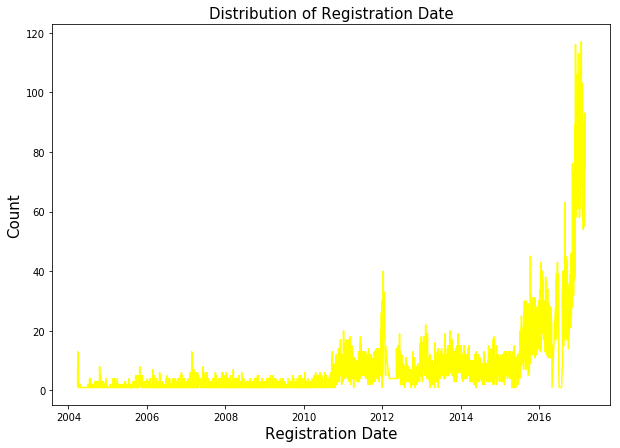

In [21]:
df = member['registration_init_time'].value_counts()
df.columns = ['Registration Date', 'Count']
plt.subplots(figsize=(10, 7))
plt.rcParams["axes.labelsize"] = 15
ax = sns.lineplot(data=df, color='yellow', size=20)
ax.set(xlabel='Registration Date', ylabel='Count')
ax.set_title("Distribution of Registration Date", fontsize=15)
plt.show()

Большинство пользователей зарегитсрировались после 2016.

# 3 Song Data Exploration

In [31]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


#### Songs имеет 7 столбцов:
`song_id`<br>
`song_length`: в миллисекундах<br>
`genre_ids`:<br>
`artist_name` <br>
`composer` <br>
`lyricist` <br>
`language` <br>

Некотрые ячейки содержат несколько значений, разделенных вертикальной чертой |

### 3.1 Let us get a summary count of the Songs data set 

In [32]:
serv.summary(songs)

Total number of records:  2296320
Distinct song_id in dataframe: 2296320
Distinct song_length in dataframe: 146534
Distinct genre_ids in dataframe: 1046
Distinct artist_name in dataframe: 222363
Distinct composer in dataframe: 329823
Distinct lyricist in dataframe: 110925
Distinct language in dataframe: 11


Видим, что в датасете почти **2.3 million** песен на **11** языках. Заметим, что число уникальных `genre_id`, `composer` и `artist name` может быть на самом деле не таким, как в результатах ячейки выше, так как в этих столбцах может быть несколько значений.

### 3.2 Проверка пропущенных значений.

In [33]:
serv.count_na(songs)

,NA_count,Percentage
song_id,0,0.000000
song_length,0,0.000000
genre_ids,94116,4.098558
artist_name,0,0.000000
composer,1071358,46.655431
lyricist,1945306,84.714064
language,1,0.000044


Столбцы `composer` и `lyricist` имеют множество пропущенных значений, что осложняет использование этих предикторов.

### 3.3 Распределение категориальных переменных.

#### Распределение языков.

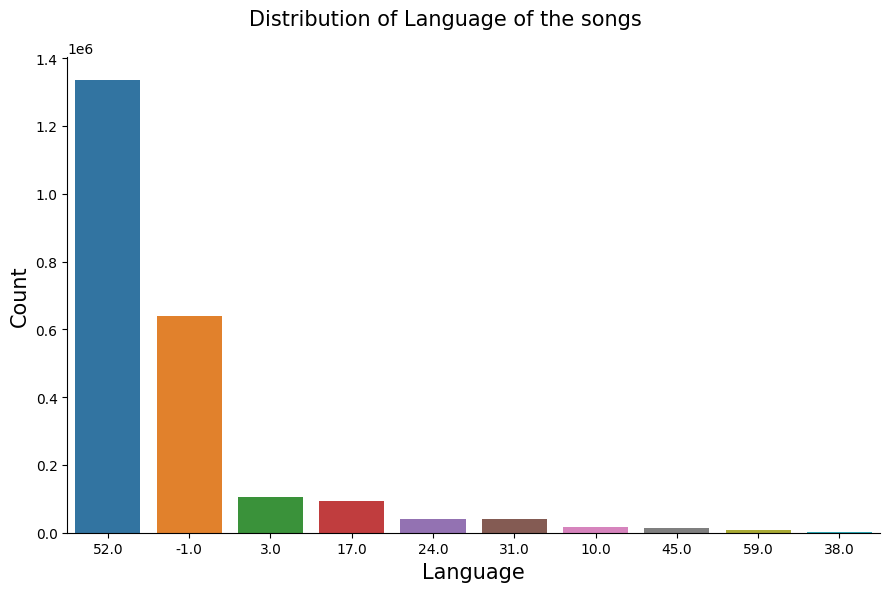

In [34]:
language = songs.groupby(['language']).size()
language = pd.DataFrame(language)
language.reset_index(level=0, inplace=True)
language.columns = ['Language', 'Count']
language = language.sort_values(by='Count', ascending=False)
language['Language'] = language['Language'].astype('str')
ax = sns.catplot(x='Language', y='Count', kind='bar', order=language['Language'],
                 hue='Language', legend=False, data=language, height=6, aspect=1.5)
ax.figure.subplots_adjust(top=.9)
ax.figure.suptitle('Distribution of Language of the songs', fontsize=15)
plt.show()

Лидеры - `52` и `-1`. Что это за языки - неизвестно, хотя логично предположить что 52 - это английский.

#### Распрделение длин песен.

count    2.296320e+06
mean     4.116558e+00
std      2.682000e+00
min      3.083333e-03
25%      3.060000e+00
50%      3.777117e+00
75%      4.621150e+00
max      2.028975e+02
Name: song_length, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_20468\1527407601.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, color='black')


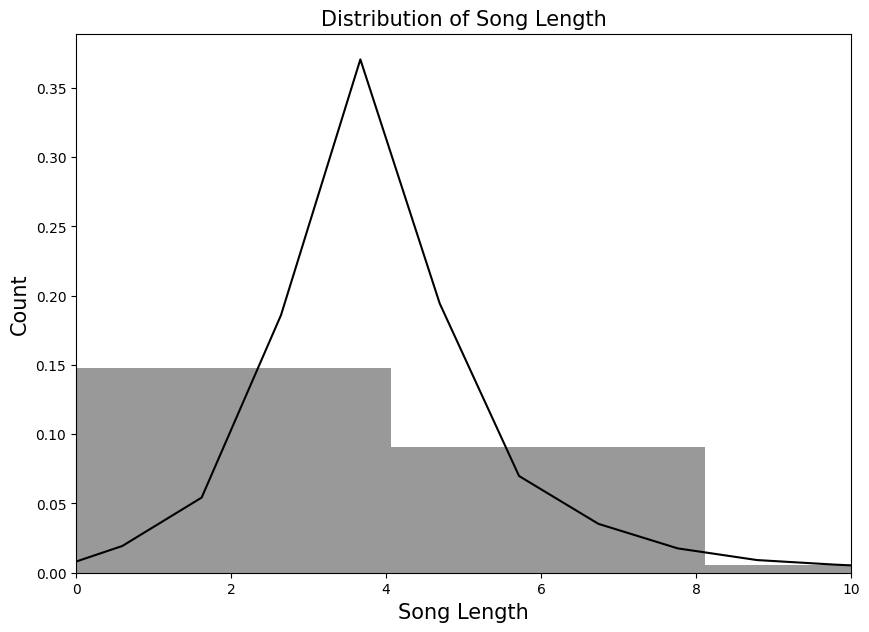

In [38]:
print((songs.song_length/60000).describe())
plt.subplots(figsize=(10, 7))
x = songs.song_length/60000
ax = sns.distplot(x, color='black')
ax.set_xlim(left=0, right=10) # скорее всего 99% песен сосредоточено в этом диапазоне
ax.set_title('Distribution of Song Length', fontsize=15)
ax.set(xlabel='Song Length', ylabel='Count')
plt.show()

#### Уникальные жанры и распределение песен по жанрам.

In [39]:
gener_count = serv.genres_separate(songs.genre_ids)

In [40]:
len(gener_count)

191

Итак, у нас **191** уникальный жанр.

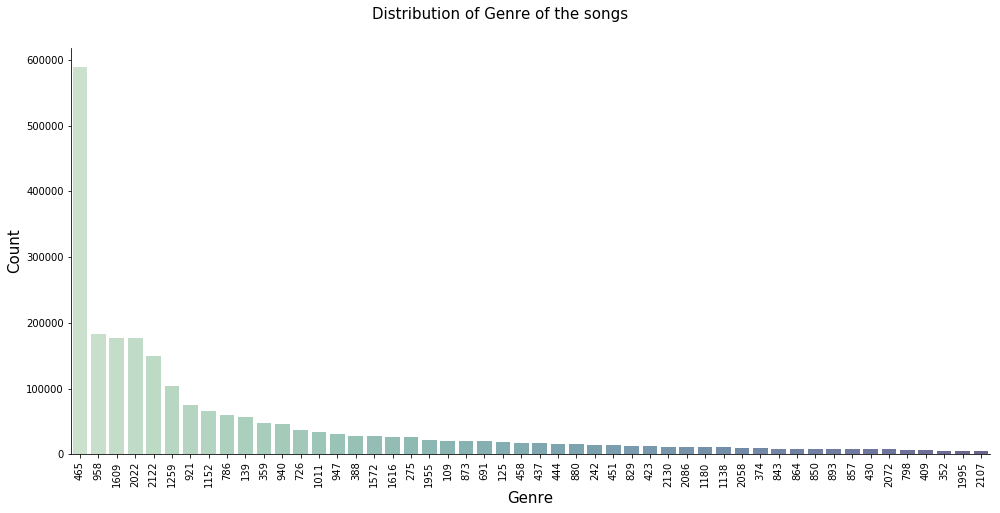

In [33]:
gener_df = pd.DataFrame.from_dict(
    gener_count, orient='index', columns=['counts'])
gener_df.reset_index(level=0, inplace=True)
gener_df = gener_df.sort_values(by='counts', ascending=False)
gener_df.columns = ['Genre', 'Count']
gener_df = gener_df[0:50]
ax = sns.catplot(x='Genre', y='Count', kind='bar', order=gener_df['Genre'],
                 palette="ch:7,-0.8,dark=.4", data=gener_df, height=7, aspect=2)
ax.figure.subplots_adjust(top=.9)
ax.figure.suptitle('Distribution of Genre of the songs', fontsize=15)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

# 4 Extra Song Data Exploration

In [41]:
extra_song.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


#### song_extra_info содержит следующие колонки:
`song_id` <br>
`song name` - название песни <br>
`isrc` - International Standard Recording Code, теоретически может использоваться в качестве идентификатора песни. Однако стоит отметить, что ISRC, сгенерированные у провайдеров, не были официально проверены; поэтому информация в ISRC, такая как код страны и год выпуска, может быть некорректна. Несколько песен могут иметь один ISRC, поскольку одна и та же запись может быть переиздана несколько раз.

### 4.1 Подсчет.

In [42]:
serv.summary(extra_song)

Total number of records:  2295971
Distinct song_id in dataframe: 2295971
Distinct name in dataframe: 1168979
Distinct isrc in dataframe: 1806826


### 4.2 Пропущенные значения.

In [43]:
serv.count_na(extra_song)

,NA_count,Percentage
song_id,0,0.000000
name,3,0.000131
isrc,136548,5.947288


**6%** данных в столбце `isrc` отсутствует.


# 5 Test  Data Exploration

#### Посмторим на тест датасет и сравним его с трэйном.

In [4]:
test = pd.read_csv('data/test.csv')
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [5]:
serv.summary(test)

Total number of records:  2556790
Distinct id in dataframe: 2556790
Distinct msno in dataframe: 25131
Distinct song_id in dataframe: 224753
Distinct source_system_tab in dataframe: 9
Distinct source_screen_name in dataframe: 23
Distinct source_type in dataframe: 13


Посмотрим на отличия от трэйна.

In [6]:
serv.test_train_diff(train, test)

{'source_type': 0,
 'source_screen_name': 2,
 'msno': 3648,
 'song_id': 59873,
 'source_system_tab': 0}

У нас есть **3648** не представленных в train сете значений `msno`, а также **2** новых `source_screen_name` и **59873** новых `song_id`.